# A/B тестирование оплаты услуг на сайте

### 1. Подготовка к работе

In [90]:
# Подгружаем библиотеки

import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from statsmodels.regression.linear_model import OLS
from tqdm.auto import tqdm
import pingouin as pg
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

from utils import download_data

In [91]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid") #тема фона, белая со штриховкой

%matplotlib inline 
#масштабируемые диаграммы

#### 2. Загрузка данных

2.1. В таблице  **groups.csv** имеется следующая информация:
* идентификатор пользователя (id)
* группа пользователя (grp) 

In [92]:
# Получаем таблицу с группами
groups_df = download_data(
    base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
    public_key='https://disk.yandex.ru/d/hmRKKZTCIr3gnQ',
    separ=';'
)

2.2. Подгружаем дополнительный файл по группам **groups_add.csv** . Структура аналогична groups.csv

In [93]:
# Получаем доп.таблицу с группами

groups_add_df = download_data(
    base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
    public_key='https://disk.yandex.ru/d/mV20xzm72xuyRg',
    separ=','
)

2.3. Подгружаем таблицу с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента **active_studs.csv** . В ней находятся только id пользователей.

In [94]:
# Получаем файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
active_studs_df = download_data(
    base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
    public_key='https://disk.yandex.ru/d/zgR4vE7CwF8RnA',
    separ=','
)

2.4. Подгружаем таблицу с информацией об оплатах пользователей в дни проведения эксперимента **checks.csv** . В ней следующая информация:
* идентификатор пользователя (student_id);
* доход (rev)

In [95]:
# Получаем файл с информацией об оплатах пользователей в дни проведения эксперимента.
checks_df = download_data(
    base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
    public_key='https://disk.yandex.ru/d/bZEXLmNevGJZeA',
    separ=';'
)

### 3. Data Validation

3.1. Проверим таблицы на null и узнаем типы данных

In [96]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [97]:
groups_add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [98]:
active_studs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [99]:
# Проверяем таблицу с участниками эксперимента на дубликаты
active_studs_df.loc[active_studs_df.duplicated()]

,student_id


In [100]:
checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [101]:
# Посмотрим описательную статистику таблиыцы checks
checks_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


#### **Вывод:** Данные можно использовать для анализа.

### 4 .Собираем общий df  

In [102]:
# 4.1. Объединим таблицы с группами, и создадим полный справочник клиентов
groups_full_df = groups_df.append(groups_add_df)
# 4.2. Посмотрим размер данных
groups_full_df.shape

/tmp/ipykernel_435/3480868327.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_full_df = groups_df.append(groups_add_df)


(74576, 2)

In [103]:
# 4.3. Проверяем на дубликаты
groups_full_df.loc[groups_full_df.duplicated()]

,id,grp


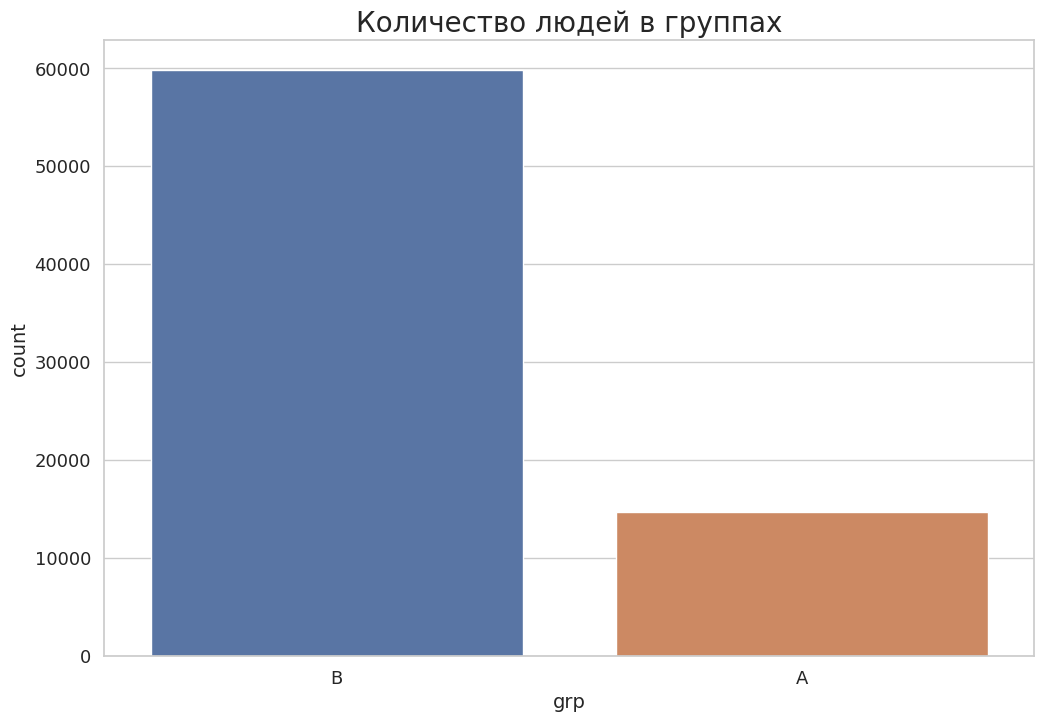

In [104]:
# 4.4. Оценим соотношение людей в группах
count_persosons = sns.countplot(x='grp', data=groups_full_df).set(title='Количество людей в группах')

In [105]:
# 4.5. Добавляем столбец info в таблицу с активными пользователями, чтобы при объединении со справочником всех пользоваталей была возможность отфильтровать активных юзеров.
active_studs_df['info'] = 'были на платформе'
# 4.6. Объединяем справочник с клиентами и таблицу с активностью
# Создаем таблицу всех юзеров с группой тестирования и инфой об активности.
all_users = pd.merge(groups_full_df, active_studs_df, how='left', left_on='id', right_on='student_id').drop(
    'student_id', axis=1)
# 4.7. К таблице с чеками добавляем юзеров, которые были на платформе в день эксперимента.
big_df = pd.merge(checks_df, all_users, how='outer', left_on='student_id', right_on='id').drop('student_id', axis=1)
big_df = big_df.query('info=="были на платформе"').set_index('id')
big_df['rev'] = big_df['rev'].fillna(0)
# 4.8. Создаем столбец -лейбл, который принимает значение 1, если пользователь совершил покупку и 0 если покупку не совершал.
big_df['converted'] = np.where(big_df.rev > 0, 1, 0)
# 4.9 Получаем общий df
big_df = big_df.reset_index()
# 4.10 df общий с участниками эксперимента
experiment_df = big_df.query('info=="были на платформе"')

# Делаем референс таблицы для задания 3
experiment_2_df = experiment_df.reset_index()

### 5. EDA 
Проведем разведовательный анализ:
1. Выясним количество вариантов оплаты (чем отличаются механики);
2. Рассмотрим распределние чеков, платящих клиентов по группам, чтобы узнать есть ли у них отличия;
3. Рассчитаем основные показатели эффективности по группам:
* **cr%** - конверсия в покупку,
* **ARPAU** -  средний платеж на всех активных пользователей,
* **ARPPU** - средний платеж на всех платящих пользователей, (более точный чем ARPAU) 


In [106]:
# 5.1. Чем отличаются механики?

# Переведем чеки в целое число и сгруппируем, чтобы посмотреть сколько вариантов оплат существует для пользователей в разных механиках.
vs_checks_df = experiment_df.astype({'rev': 'int'})
a_checks = (
    vs_checks_df.query('grp=="A" & rev>0')
    .rev.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'check', 'rev': 'clients_a'})
    .sort_values('check')
)
b_checks = (
    vs_checks_df.query('grp=="B" & rev>0')
    .rev.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'check', 'rev': 'clients_b'})
    .sort_values('check')
)
# 5.1. Узнаем количество вариантов оплаты по группам. (чем отличаются механики)
payment_variants = vs_checks_df.query('rev>0 ').groupby('grp').agg({'rev': 'nunique'}).reset_index()
payment_variants.style.set_caption("Количество вариантов оплаты по группам (отличие механик)")

,grp,rev
0,A,23
1,B,32


<Axes: xlabel='grp', ylabel='rev'>

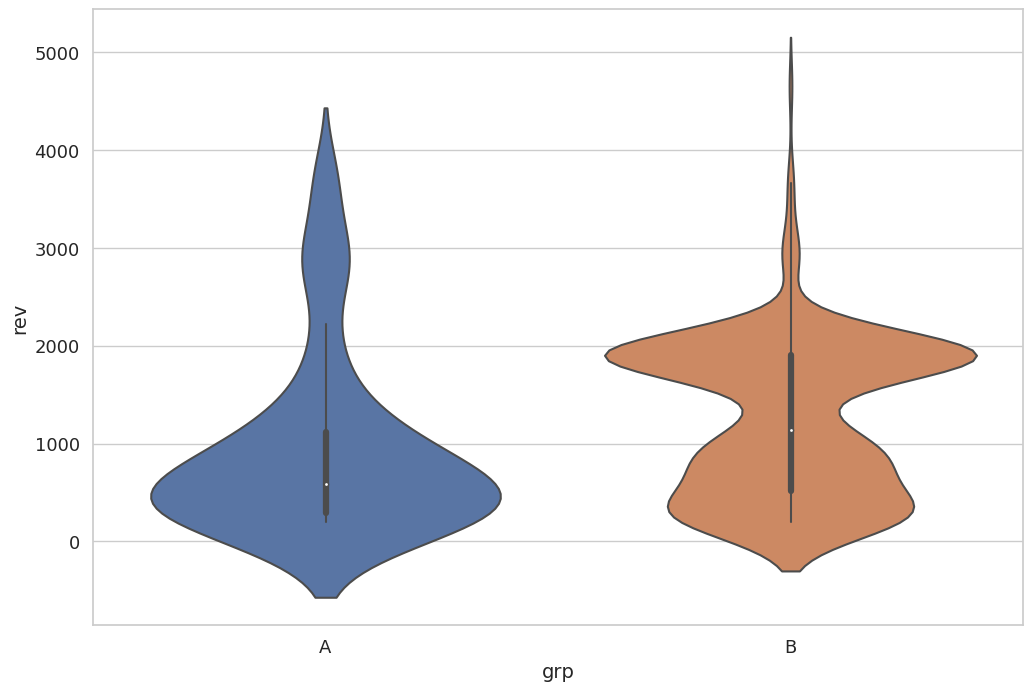

In [107]:
# 5.2. Построим violin chart, чтобы посмотреть на распределение чеков в группах.
sns.violinplot(data=experiment_df[experiment_df['rev'] > 0], x="grp", y="rev")

**Вывод:** Из графика видно, что в группе B медиана находится выше, больше вариабильности чеков, а также значительная часть чеков находится в районе 2000, в то время как в группе А большая плотность нижк 1000.

In [108]:
# Считаем конвесии на каждого пользователя (на случай если есть повторные покупки)
experiment_df_cr = (
    experiment_df.groupby(['grp', 'id'])
    .agg({'converted': 'sum'})
    .reset_index()
    .sort_values('converted', ascending=False)
)

# Считаем отдельно конверсии = 0 и 1
groups_df = experiment_df_cr.pivot_table(index='grp', columns='converted', aggfunc='size', fill_value=0)
groups_df.columns = ['converted_0', 'converted_1']
groups_df = groups_df.reset_index()
groups_df['total_conversions'] = groups_df['converted_0'] + groups_df['converted_1']
# Получаем CR
groups_df['conversion_rate'] = groups_df['converted_1'] / groups_df['total_conversions']

# считаем доход по группам
rev_4_grp_df = experiment_df.groupby('grp').agg(rev=('rev', 'sum'), users=('id', 'nunique')).reset_index()
# считаем количество платящих пользователей
paying_users_df = (
    experiment_df.query('converted==1').reset_index().groupby('grp').agg(paying_users=('id', 'nunique')).reset_index()
)
# Добавляем к df столбцы с доходо и количеством пользователей
groups_df = groups_df.merge(rev_4_grp_df, on='grp')
groups_df = groups_df.merge(paying_users_df, on='grp')
# Считаем ARPAU
groups_df['arpau'] = groups_df['rev'] / groups_df['users']
# Считаем ARPPU
groups_df['arppu'] = groups_df['rev'] / groups_df['paying_users']
groups_df = groups_df.set_index('grp')

In [109]:
groups_df.head()

,converted_0,converted_1,total_conversions,conversion_rate,rev,users,paying_users,arpau,arppu
grp,,,,,,,,,
A,1460,78,1538,0.050715,72820.0000,1538,78,47.347204,933.589744
B,6489,314,6803,0.046156,394974.0035,6803,314,58.058798,1257.878992


In [110]:
# Вывод по CR%

# Извлекаем значения CR для групп 'A' и 'B'
cr_a = groups_df.loc['A', 'conversion_rate']
cr_b = groups_df.loc['B', 'conversion_rate']
# Вычисляем разницу в процентах (CR)
difference_cr = (cr_b - cr_a) / cr_a * 100
# Пишем заключение по CR
conclusion_cr = f" Вывод: Разница в CR% между группами 'A' и 'B': {difference_cr:.2f}%"

# Вывод по ARPAU%
# Извлекаем значения ARPAU для групп 'A' и 'B'
arpau_a = groups_df.loc['A', 'arpau']
arpau_b = groups_df.loc['B', 'arpau']
# Вычисляем разницу в процентах (ARPAU)
difference_arpau = (arpau_b - arpau_a) / arpau_a * 100
# Пишем заключение по ARPAU
conclusion_arpau = f"в ARPAU% : {difference_arpau:.2f}%"

# Вывод по ARPPU%
# Извлекаем значения ARPPU для групп 'A' и 'B'
arppu_a = groups_df.loc['A', 'arppu']
arppu_b = groups_df.loc['B', 'arppu']
# Вычисляем разницу в процентах (ARPPU)
difference_arppu = (arppu_b - arppu_a) / arppu_a * 100
# Пишем заключение по CR
conclusion_arppu = f"в ARPPU% : {difference_arppu:.2f}%"

print(conclusion_cr, conclusion_arpau, conclusion_arppu)

 Вывод: Разница в CR% между группами 'A' и 'B': -8.99% в ARPAU% : 22.62% в ARPPU% : 34.74%


 ## 6. Проверка гипотез 
### 6.1. Фиксируем гипотезы (CR)
**H0** - новая механика оплаты услуг на сайте НЕ влияет на конверсию в покупку <br>
**H1** - новая механика оплаты услуг на сайте влияет на конверсию в покупку <br> 
<br> Уровень значимости p= 0.05 <br>

Мы  анализируем категориальные переменные, поэтому выбираем хи-тест.


In [111]:
# 6.1. Готовим таблицу для хи-теста

# Оставляем только нужные столбцы из df
experiment_2_df = experiment_2_df[['grp', 'converted']]
# 1) разделяем группы на два отдельных датафрейма
a = experiment_2_df[experiment_2_df['grp'] == 'A']
b = experiment_2_df[experiment_2_df['grp'] == 'B']
# 2) A-purchase, A-nopurchase, B-purchase, B-nopurchase
a_purchase = a.converted.sum()
a_nopurchase = a.converted.size - a.converted.sum()
b_purchase = b.converted.sum()
b_nopurchase = b.converted.size - b.converted.sum()
# 3) Создаем массив
T = np.array([[a_purchase, a_nopurchase], [b_purchase, b_nopurchase]])

# 6.2. Запускаем тест
# print(scipy.stats.chi2_contingency(T, correction=False)[1])
hitest_result = scipy.stats.chi2_contingency(T, correction=False)[1]
if hitest_result < 0.05:
    hitest_conclusion = f'Вывод: p-value= {hitest_result} меньше 0.05. Существуют статистически значимые различия. Отклоняем нулевую гипотезу.'
else:
    hitest_conclusion = f'Вывод: p-value=  {hitest_result} больше или равно 0.05. Статистически значимых различий нет. Проще говоря, нет никакой разницы в конверсиях между старой и новой механикой оплаты.'
hitest_conclusion

'Вывод: p-value=  0.44547028437158964 больше или равно 0.05. Статистически значимых различий нет. Проще говоря, нет никакой разницы в конверсиях между старой и новой механикой оплаты.'

### 6.2. Фиксируем гипотезы (Average Revenue Per Paying User) <br>
**H0** - новая механика оплаты услуг на сайте НЕ влияет на ARPPU <br>
**H1** - новая механика оплаты услуг на сайте влияет на ARPPU <br> 
<br> Уровень значимости p= 0.05 <br>
Исходя из условия задачи (попытка сравнить средние генеральной совокупности) нам  больше подходит t-test. 
Предварительно необходимо проверить данные на соответствия требованиям применения t-testа:
* Требование на нормальность;
* Требование на гомогенность дисперсий.

<Axes: xlabel='rev', ylabel='Density'>

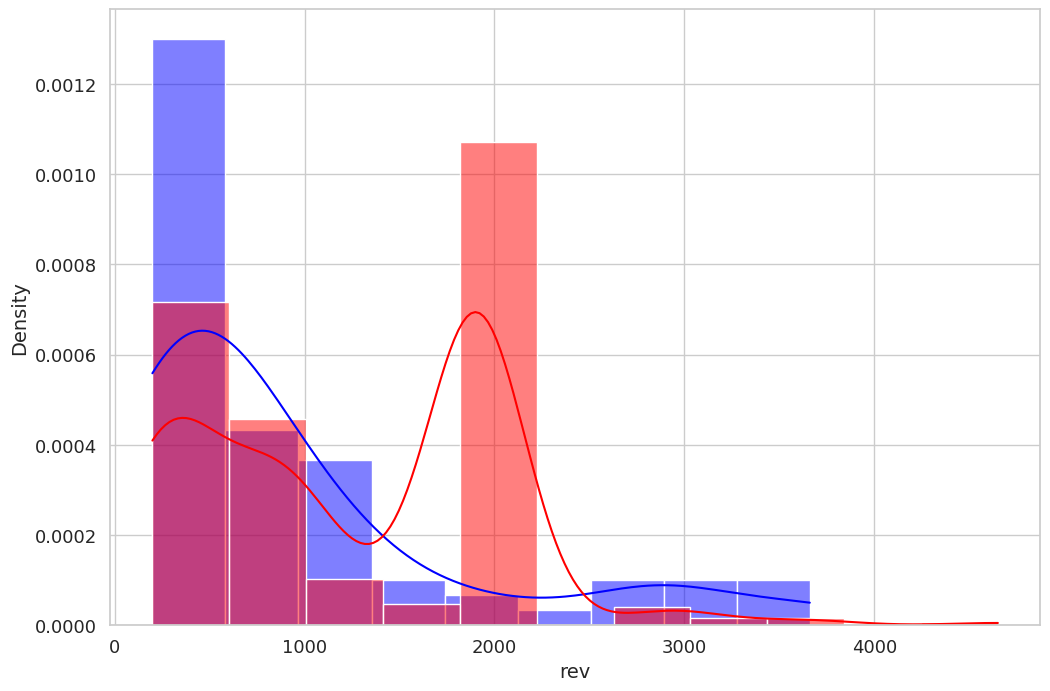

In [112]:
# 6.2.1. Проверим требование к нормальности данных обеих групп при применении t-теста с помощью графиков и теста на нормальность

sns.histplot(data=experiment_df.query('rev>0 & grp=="A"')['rev'], kde=True, stat='density', color='blue', label='A')
sns.histplot(data=experiment_df.query('rev>0 & grp=="B"')['rev'], kde=True, stat='density', color='red', label='B')

**Вывод:** Ярко выражена ассиметрия, большая часть наблюдений кучкуется в одном месте и есть несколько выделяющихся значений.Фактически это будет влиять на среднее так же, как и выбросы.

In [113]:
# Проверим данные на нормальность с помощью теста
pg.normality(experiment_df.query('rev>0'), dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


In [114]:
# 6.2.2. Сделаем проверку на гомогенность дисперсий
pg.homoscedasticity(experiment_df.query('rev>0'), dv='rev', group='grp')

,W,pval,equal_var
levene,3.075682,0.080257,True


**Вывод:** Отклонения от нормальности не так критичны. (нормальность выборочного распределения по ЦПТ не является критичной для t-теста при большом количестве наблюдений), следовательно можем применить t-test.

#### 6.2.2. Проводим t-test (ARPPU)

In [115]:
# p-value T-test
t_test_result = stats.ttest_ind(
    experiment_df.query('rev>0 & grp=="A"')['rev'], experiment_df.query('rev>0 & grp=="B"')['rev']
)

p_value = t_test_result[1]
if p_value < 0.05:
    ttest_conclusion = (
        "Вывод: p-value меньше 0.05. Существуют статистически значимые различия. Отклоняем нулевую гипотезу."
    )
else:
    ttest_conclusion = "Вывод: p-value больше или равно 0.05. Статистически значимых различий нет."
b_mean = experiment_df.query('rev>0 & grp=="B"')['rev'].mean()
a_mean = experiment_df.query('rev>0 & grp=="A"')['rev'].mean()

percent = np.round((b_mean - a_mean) / a_mean * 100, 2)
conclusion_difference = f"Результат между тестом и контролем (в средних) составил " + str(percent) + "%"
print(ttest_conclusion, conclusion_difference)

Вывод: p-value меньше 0.05. Существуют статистически значимые различия. Отклоняем нулевую гипотезу. Результат между тестом и контролем (в средних) составил 34.74%


### 6.3. Фиксируем гипотезы (Average Revenue Per Active User) <br>
**H0** - новая механика оплаты услуг на сайте НЕ влияет на ARPAU <br>
**H1** - новая механика оплаты услуг на сайте влияет на ARPAU <br> 
<br> Уровень значимости p= 0.05 <br>
Исходя из условия задачи (попытка сравнить средние генеральной совокупности) нам  больше подходит t-test. 
Проверим данные на соответствия требованиям применения t-testа:
* Требование на нормальность;
* Требование на гомогенность дисперсий.

In [116]:
# 6.3.1. Проверим данные на нормальность с помощью теста
pg.normality(experiment_df, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,2240.595797,0.0,False
B,7797.399212,0.0,False


In [117]:
# 6.3.2. Сделаем проверку на гомогенность дисперсий
pg.homoscedasticity(experiment_df, dv='rev', group='grp')

,W,pval,equal_var
levene,1.501461,0.220481,True


**Вывод:** Отклонения от нормальности не так критичны. (нормальность выборочного распределения по ЦПТ не является критичной для t-теста при большом количестве наблюдений), следовательно можем применить t-test.

#### 6.3.2. Проводим t-test (ARPAU)

In [118]:
# p-value T-test
t_test_result = stats.ttest_ind(experiment_df.query('grp=="A"')['rev'], experiment_df.query('grp=="B"')['rev'])

p_value = t_test_result[1]
if p_value < 0.05:
    ttest_conclusion = (
        f'Вывод: {p_value} меньше 0.05. Существуют статистически значимые различия. Отклоняем нулевую гипотезу.'
    )
else:
    ttest_conclusion = f'Вывод: {p_value} больше или равно 0.05. Статистически значимых различий нет.'
b_mean = experiment_df.query('grp=="B"')['rev'].mean()
a_mean = experiment_df.query('grp=="A"')['rev'].mean()

percent = np.round((b_mean - a_mean) / a_mean * 100, 2)
conclusion_difference = f"Результат между тестом и контролем (в средних) составил " + str(percent) + "%"
print(ttest_conclusion)

Вывод: 0.22048133326988414 больше или равно 0.05. Статистически значимых различий нет.


## ЗАКЛЮЧЕНИЕ

В проведенном анализе учитывали только активных пользователей, которые во время эксперимента посещали платформу и/или производили оплату. Оценка эффективности новой механики оплаты основана на следующих показателях:

1) Конверсия в покупку (CR): чтобы определить, насколько успешно новая механика приводит к увеличению числа покупок.

2) Средний доход на активного пользователя (ARPU) и средний доход на платящего пользователя (ARPPU): эти показатели помогают измерить, насколько новая механика оплаты влияет на лояльность клиентов и выражает ценность сделанных изменений финансово.

В результате анализа выявлено, что изменение механики оплаты значительно влияет на средний доход на платящего пользователя (ARPPU в тестовой группе превышает этот показатель в контрольной группе на 34,7%) с достоверным статистическим значимым эффектом. При этом новая механика не оказывает статистически значимого влияния на средний доход на пользователя (ARPAU) и конверсию в покупку.

**Рекомендация**: Следует запустить новую механику оплаты услуг на всех пользователях. Улучшение ARPPU на 34,74% является значительным и может привести к повышению доходности и росту выручки компании.


## Задание 3.

#### Задача 3.1. Решение

In [119]:
def get_groups_add():
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/mV20xzm72xuyRg'
    # получаем url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url_orders = response.json()['href']
    # загружаем файл в df
    groups_add_task3 = pd.read_csv(download_url_orders, sep=',')
    groups_full = groups_df.append(groups_add_task3)
    # Создаем таблицу всех юзеров с группой тестирования и инфой об активности.
    all_users = pd.merge(groups_full, active_studs_df, how='left', left_on='id', right_on='student_id').drop(
        'student_id', axis=1
    )
    # big_df = pd.merge(checks_df, all_users, how='outer', left_on='student_id', right_on='id').drop('student_id', axis=1)
    # big_df = big_df.query('info=="были на платформе" or rev>0').set_index('id')
    # big_df['rev'] = big_df['rev'].fillna(0)
    # # Создаем столбец -лейбл, который принимает значение 1, если пользователь совершил покупку и 0 если покупку не совершал.
    # big_df['converted'] = np.where(big_df.rev > 0, 1, 0)
    # groups = (
    #     big_df.reset_index()
    #     .groupby(['grp'])
    #     .agg(ids=('id', 'size'), revenue=('rev', 'sum'), converted=('converted', 'sum'))
    # )
    # # Добавляем столбец с MRPPU
    # groups = pd.concat([groups, mrppu_by_groups], axis=1)
    # #  Считаем клиентов, которые не делали покупок
    # groups['unconverted'] = groups['ids'] - groups['converted']
    # # Считаем % клиентов, которые не делали покупок
    # groups['part_unconv_%'] = np.round(((groups['unconverted'] / groups['ids']) * 100), 2)
    # # Считаем CR%
    # groups['cr_%'] = round(((groups.converted / groups.ids) * 100), 2)
    # groups['revenue'] = np.round((groups.revenue), 2)
    # # # Посчитаем разницу в CR между группами в %
    # groups['diff%_cr_B-A'] = np.round(
    #     ((groups.loc['B']['cr_%'] - groups.loc['A']['cr_%']) / groups.loc['A']['cr_%']), 2
    # )
    # # Посчитаем разницу в ARPU между группами абсолют. и в %
    # groups['ARPU'] = np.round((groups.revenue / groups.ids), 2)
    # groups['diff%_ARPU_B-A'] = np.round(
    #     (((groups.loc['B']['ARPU'] - groups.loc['A']['ARPU']) / groups.loc['A']['ARPU']) * 100), 2
    # )
    # # Посчитаем разницу в ARPPU между группами абсолют. и в %
    # groups['ARPPU'] = np.round((groups.revenue / groups.converted), 2)
    # # groups['diff_ARPPU_B-A'] = np.round((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']),2)
    # groups['diff%_ARPPU_B-A'] = np.round(
    #     (((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']) / groups.loc['A']['ARPPU']) * 100), 2
    # )
    # groups['diff%_MRPPU_B-A'] = np.round(
    #     (((groups.loc['B']['MRPPU'] - groups.loc['A']['MRPPU']) / groups.loc['A']['MRPPU']) * 100), 2
    # )
    # # Посчитаем % клиентов в группах
    # groups['%_clients'] = np.round(((groups['ids'] / (groups.loc['A']['ids'] + groups.loc['B']['ids'])) * 100), 2)
    # f_one_result = groups.reset_index()[
    #     [
    #         'grp',
    #         '%_clients',
    #         'cr_%',
    #         'ARPU',
    #         'ARPPU',
    #         'MRPPU',
    #         'diff%_cr_B-A',
    #         'diff%_ARPU_B-A',
    #         'diff%_ARPPU_B-A',
    #         'diff%_MRPPU_B-A',
    #     ]
    # ]
    # return f_one_result
    return all_users

#### Задача 3.1. Результат

In [120]:
get_groups_add()

/tmp/ipykernel_435/3771277740.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_full = groups_df.append(groups_add_task3)


,converted_0,converted_1,total_conversions,conversion_rate,rev,users,paying_users,arpau,arppu,id,grp,info
0,1460.0,78.0,1538.0,0.050715,72820.0000,1538.0,78.0,47.347204,933.589744,NaN,NaN,NaN
1,6489.0,314.0,6803.0,0.046156,394974.0035,6803.0,314.0,58.058798,1257.878992,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5694584.0,B,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5694830.0,B,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5695057.0,B,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200247820.0,B,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201032527.0,B,NaN
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201067612.0,B,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201067653.0,B,NaN


#### Задача 3.2. Решение

In [121]:
f_one_result = get_groups_add()

/tmp/ipykernel_435/3771277740.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_full = groups_df.append(groups_add_task3)


In [122]:
def visuals_total(param):
    param = param[['diff%_cr_B-A', 'diff%_ARPU_B-A', 'diff%_ARPPU_B-A', 'diff%_MRPPU_B-A']]
    param = (
        param.stack()
        .to_frame()
        .reset_index()
        .query('level_0==0')
        .rename(columns={'level_0': 'index', 'level_1': 'metric'})
    )
    param = param.rename(columns={param.columns[2]: 'B_vs_A_%'})
    param['A'] = 100 + a_vs_b_deviation['B_vs_A_%']
    param['B'] = 100 - a_vs_b_deviation['B_vs_A_%']
    param = (
        param[['metric', 'A', 'B']].set_index('metric').plot(kind='bar', stacked=False, color=['#4c72b0', '#dd8452'])
    )
    return param

#### Задача 3.2. Результат

In [123]:
visuals_total(f_one_result)

KeyError: "None of [Index(['diff%_cr_B-A', 'diff%_ARPU_B-A', 'diff%_ARPPU_B-A', 'diff%_MRPPU_B-A'], dtype='object')] are in the [columns]"